In [1]:
# Suppress annoying warning messages
import warnings
warnings.filterwarnings(action='ignore', category=Warning)

# Basic modules
import numpy as np
import pandas as pd
from scipy import interpolate
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt

# Contains functions to calculate torque, magnetic radius etc
from accretion_utils import *

%matplotlib inline

## Load tabulated EoS data

In [2]:
# Import tabulated data

ACB5file = np.genfromtxt("data/M_R_J_merged_ACB5.dat")

mass_tab = ACB5file[:,0]                 # value given in M_sol
radius_tab = ACB5file[:,1]               # value given in km
angular_momentum_tab = ACB5file[:,2]     # value given in G M_sun^2 / c
spin_frequency_tab = ACB5file[:,3]       # value given in Hz




# Interpolate relation between mass, radius, angular_momentum and angular velocity for ACB5

# Interpolation functions
radius_ip = interpolate.Rbf(mass_tab,
                            angular_momentum_tab,
                            radius_tab,
                            function='linear'
                           ) # use only without units (M_sun and G M_sun^2 / c)


spin_frequency_ip = interpolate.Rbf(mass_tab,
                                    angular_momentum_tab,
                                    spin_frequency_tab,
                                    function='linear'
                                   ) # use only values without units (M_sun and G M_sun^2 / c)

In [3]:
# Canonical neutron star properties
magnetic_field = 1e8 * u.gauss
inclination_angle = (np.pi / 2) * u.rad
zone_width = 0.02
factor_phi = 1.0
factor_xi = 1.0

# Angular momentum normalization
J0 = (const.M_sun**2) * (const.G / const.c)

## Load MESA simulation data

In [4]:
# 3 examples
# -----------
# i) no phase transition
# ii) phase transition during accretion
# iii) phase transition after accretion

# No phase transition model
bin_data_case1 = np.genfromtxt(
    "data/md1.0_mc1.0_p8.0_z0.02_b0.5/binary_history.data", skip_header=5, names=True
)
data_case1 = np.genfromtxt(
    "data/md1.0_mc1.0_p8.0_z0.02_b0.5/history.data",
    skip_header=5,
    skip_footer=1,
    names=True,
)

# Phase transition during accretion
bin_data_case2 = np.genfromtxt(
    "data/md1.0_mc1.2_p8.0_z0.02_b0.5/binary_history.data", skip_header=5, names=True
)
data_case2 = np.genfromtxt(
    "data/md1.0_mc1.2_p8.0_z0.02_b0.5/history.data",
    skip_header=5,
    skip_footer=1,
    names=True,
)

# Phase transition after accretion
bin_data_case3 = np.genfromtxt(
    "data/md1.0_mc1.2_p22.627_z0.02_b0.5/binary_history.data", skip_header=5, names=True
)
data_case3 = np.genfromtxt(
    "data/md1.0_mc1.2_p22.627_z0.02_b0.5/history.data",
    skip_header=5,
    skip_footer=1,
    names=True,
)

(12.2, 12.3)

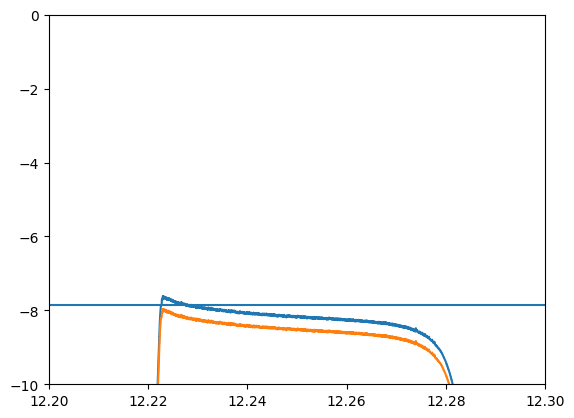

In [5]:
plt.plot(bin_data_case2['age']/1e9, bin_data_case2['lg_mtransfer_rate'])
# plt.plot(bin_data_case2['age']/1e9, bin_data_case2['lg_mstar_dot_1'])
plt.plot(bin_data_case2['age']/1e9, bin_data_case2['lg_mstar_dot_2'])

edd = lambda m : 1.5 * 1e-8 * (m/1.3)

plt.axhline(np.log10(edd(1.2)))

plt.ylim([-10, 0])
plt.xlim([12.2, 12.3])

(12.2, 12.4)

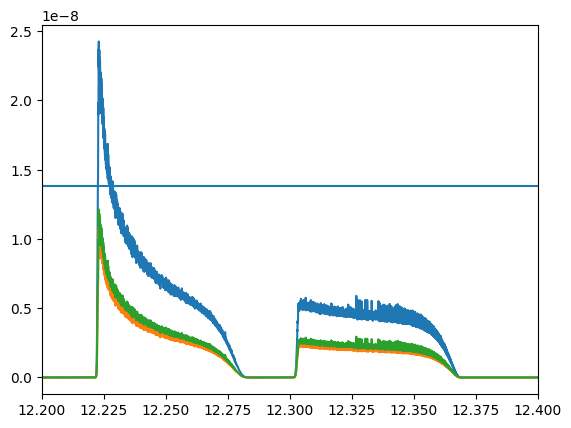

In [6]:
mdot_accretion = bin_data_case2['lg_mstar_dot_2']
mdot_accretion[mdot_accretion > 0] = mdot_accretion[0]
mdot_accretion = 10**mdot_accretion

mdot_transfer = bin_data_case2['lg_mtransfer_rate']
mdot_transfer[mdot_transfer > 0] = mdot_transfer[0]
mdot_transfer = 10**mdot_transfer


plt.plot(bin_data_case2['age']/1e9, mdot_transfer)
plt.plot(bin_data_case2['age']/1e9, mdot_accretion)

plt.plot(bin_data_case2['age']/1e9, 0.5*mdot_transfer)

edd = lambda m : 1.5 * 1e-8 * (m/1.3)


plt.axhline(edd(1.2))

plt.xlim([12.2,12.4])

In [7]:
lg_mtransfer_rate = bin_data_case1['lg_mtransfer_rate']
lg_mtransfer_rate[lg_mtransfer_rate > 0] = lg_mtransfer_rate[0] #exclude some weird values
mass_transfer_rate_case1 = 10 ** lg_mtransfer_rate * (u.M_sun / u.yr)

age_case1 = bin_data_case1['age'] * u.yr
# time_step_case1 = data_case1['time_step'] * u.yr
# ns_mass_case1 = bin_data_case1['star_2_mass'] * u.M_sun

# ---

lg_mtransfer_rate = bin_data_case2['lg_mtransfer_rate']
lg_mtransfer_rate[lg_mtransfer_rate > 0] = lg_mtransfer_rate[0] #exclude some weird values
mass_transfer_rate_case2 = 10 ** lg_mtransfer_rate * (u.M_sun / u.yr)

age_case2 = bin_data_case2['age'] * u.yr
# time_step_case2 = data_case2['time_step'] * u.yr
# ns_mass_case2 = bin_data_case2['star_2_mass'] * u.M_sun

# ---

lg_mtransfer_rate = bin_data_case3['lg_mtransfer_rate']
lg_mtransfer_rate[lg_mtransfer_rate > 0] = lg_mtransfer_rate[0] #exclude some weird values
mass_transfer_rate_case3 = 10 ** lg_mtransfer_rate * (u.M_sun / u.yr)

age_case3 = bin_data_case3['age'] * u.yr
# time_step_case3 = data_case3['time_step'] * u.yr
# ns_mass_case3 = bin_data_case3['star_2_mass'] * u.M_sun

In [8]:
def edd_limit(m):
    m = u.Quantity(m, u.Msun)
    return 1.5 * 1e-8 * (m/(1.3 * u.Msun))

## Radius and spin evolution

### Case 1: No phase transition

In [9]:
# Define relevant arrays
angular_momentum_case1 = np.zeros_like(age_case1.value)
ns_radius_case1 = np.zeros_like(age_case1.value) * u.km
ns_fspin_case1 = np.zeros_like(age_case1.value) * u.hertz
ns_fspin_eq_case1 = np.zeros_like(age_case1.value) * u.hertz
ns_mass_case1 = np.zeros_like(age_case1.value) * u.Msun
torque_case1 = np.zeros_like(age_case1.value) * (u.kg * (u.m**2) / (u.s**2))
r_mag_case1 = np.zeros_like(age_case1.value) * u.m
r_cor_case1 = np.zeros_like(age_case1.value) * u.m
r_lc_case1 = np.zeros_like(age_case1.value) * u.m
fastness_param_case1 = np.zeros_like(age_case1.value)
mass_accretion_rate_case1 = np.zeros_like(age_case1.value) * (u.Msun / u.yr)


# The timestep
delta_t_case1 = u.Quantity(np.diff(age_case1.value), u.yr)


# Calculate radius and spin evolution for case 1
for i in range(len(age_case1)):
    if i == 0:
        ns_mass_case1[i] = bin_data_case1["star_2_mass"][0] * u.Msun

        angular_momentum_case1[i] = 0
        
        ns_radius_case1[i] = (
            radius_ip(ns_mass_case1[i].value, angular_momentum_case1[i]) * u.km
        )

        ns_fspin_case1[i] = (
            spin_frequency_ip(ns_mass_case1[i].value, angular_momentum_case1[i])
            * u.hertz
        )
        
        # Initialization of mass acrretion rate (capped by Eddington limit)
        edd_accretion_limit_case1 = edd_limit(ns_mass_case1[i])
        if mass_transfer_rate_case1[i].value > edd_accretion_limit_case1.value:
            mass_accretion_rate_case1.value[i] = edd_accretion_limit_case1.value
        else:
            mass_accretion_rate_case1[i] = mass_transfer_rate_case1[i]

        torque_case1[i] = accretion_torque(
            Mdot=mass_accretion_rate_case1[i],
            fspin=ns_fspin_case1[i],
            B=magnetic_field,
            M=ns_mass_case1[i],
            R=ns_radius_case1[i],
            i=inclination_angle,
            phi=factor_phi,
            xi=factor_xi,
            delta_omega=zone_width,
        )

        r_mag_case1[i] = magnetic_radius(
            Mdot=mass_accretion_rate_case1[i],
            B=magnetic_field,
            R=ns_radius_case1[i],
            M=ns_mass_case1[i],
            phi=factor_phi,
        )

        r_cor_case1[i] = corotation_radius(fspin=ns_fspin_case1[i], M=ns_mass_case1[i])
        r_lc_case1[i] = lc_radius(ns_fspin_case1[i])

        ns_fspin_eq_case1[i] = eq_spin_frequency(ns_mass_case1[i], r_mag_case1[i])

        fastness_param_case1[i] = 0
            
    else:
       
        if mass_transfer_rate_case1[i].value > edd_accretion_limit_case1.value:
            mass_accretion_rate_case1.value[i] = edd_accretion_limit_case1.value
        else:
            mass_accretion_rate_case1[i] = mass_transfer_rate_case1[i]

        if fastness_param_case1[i - 1] <= 1:
            ns_mass_case1[i] = ns_mass_case1[i - 1] + (
                1.0 * mass_accretion_rate_case1[i - 1] * delta_t_case1[i - 1]
            )
        else:
            ns_mass_case1[i] = ns_mass_case1[i - 1]
            

        angular_momentum_case1[i] = angular_momentum_case1[i-1] + ((torque_case1[i-1]*delta_t_case1[i-1])/J0)
        ns_radius_case1[i] = (
            radius_ip(ns_mass_case1[i].value, angular_momentum_case1[i]) * u.km
        )

        ns_fspin_case1[i] = (
            spin_frequency_ip(ns_mass_case1[i].value, angular_momentum_case1[i])
            * u.hertz
        )

        torque_case1[i] = accretion_torque(
            Mdot=mass_accretion_rate_case1[i],
            fspin=ns_fspin_case1[i],
            B=magnetic_field,
            M=ns_mass_case1[i],
            R=ns_radius_case1[i],
            i=inclination_angle,
            phi=factor_phi,
            xi=factor_xi,
            delta_omega=zone_width,
        )

        r_mag_case1[i] = magnetic_radius(
            Mdot=mass_accretion_rate_case1[i],
            B=magnetic_field,
            R=ns_radius_case1[i],
            M=ns_mass_case1[i],
            phi=factor_phi,
        )

        r_cor_case1[i] = corotation_radius(fspin=ns_fspin_case1[i], M=ns_mass_case1[i])
        r_lc_case1[i] = lc_radius(ns_fspin_case1[i])

        ns_fspin_eq_case1[i] = eq_spin_frequency(ns_mass_case1[i], r_mag_case1[i])

        fastness_param_case1[i] = fastness_parameter(
            r_mag_case1[i].to(u.m), r_cor_case1[i].to(u.m)
        )

In [10]:
data_case1 = {
    "age [yr]" : age_case1.value,
    "donor_star_mass [Msun]" : bin_data_case1["star_1_mass"],
    "donor_star_radius [Rsun]" : bin_data_case1["star_1_radius"],
    "mass_transfer_rate [Msun/yr]" : mass_transfer_rate_case1.value,
    "mass_accretion_rate [Msun/yr]" : mass_accretion_rate_case1.value,
    "neutron_star_mass [Msun]" : ns_mass_case1.value,
    "neutron_star_radius [km]" : ns_radius_case1.value,
    "neutron_star_angular_momentum [Msun^2 / (c * G)]" : angular_momentum_case1,
    "neutron_star_spin_frequency [Hz]" : ns_fspin_case1.value,
    "neutron_star_spin_equilibrium_frequency [Hz]" : ns_fspin_eq_case1,
    "neutron_star_torque [kg * m^2 / s^2]" : torque_case1.value,
    "neutron_star_magnetic_radius [km]" : r_mag_case1.to(u.km).value,
    "neutron_star_corotation_radius [km]" : r_cor_case1.to(u.km).value,
    "neutron_star_light_cylinder_radius [km]" : r_lc_case1.to(u.km).value,
    "binary_separation [Rsun]" : bin_data_case1["binary_separation"],
    "orbital_period [days]" : bin_data_case1["period_days"]
}

df1 = pd.DataFrame(data_case1)
df1

,age [yr],donor_star_mass [Msun],donor_star_radius [Rsun],mass_transfer_rate [Msun/yr],mass_accretion_rate [Msun/yr],neutron_star_mass [Msun],neutron_star_radius [km],neutron_star_angular_momentum [Msun^2 / (c * G)],neutron_star_spin_frequency [Hz],neutron_star_spin_equilibrium_frequency [Hz],neutron_star_torque [kg * m^2 / s^2],neutron_star_magnetic_radius [km],neutron_star_corotation_radius [km],neutron_star_light_cylinder_radius [km],binary_separation [Rsun],orbital_period [days]
0,1.000000e+05,1.000000,0.897205,1.000000e-99,1.000000e-99,1.000000,13.301571,0.000000e+00,1.014265,8.903125e-37,-3.546970e+16,1.618660e+27,1483.940419,47042.412088,21.202647,8.000000
1,2.200000e+05,1.000000,0.897208,1.000000e-99,1.000000e-99,1.000000,13.301571,-1.525970e-13,1.014265,8.903125e-37,-3.546970e+16,1.618660e+27,1483.940419,47042.412115,21.202647,7.999999
2,3.640000e+05,1.000000,0.897198,1.000000e-99,1.000000e-99,1.000000,13.301571,-3.357134e-13,1.014265,8.903125e-37,-3.546970e+16,1.618660e+27,1483.940419,47042.412109,21.202646,7.999999
3,5.368000e+05,1.000000,0.897167,1.000000e-99,1.000000e-99,1.000000,13.301571,-5.554530e-13,1.014265,8.903125e-37,-3.546970e+16,1.618660e+27,1483.940420,47042.412158,21.202645,7.999998
4,7.441600e+05,1.000000,0.897102,1.000000e-99,1.000000e-99,1.000000,13.301571,-8.191406e-13,1.014265,8.903125e-37,-3.546970e+16,1.618660e+27,1483.940421,47042.412223,21.202644,7.999998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46645,1.246401e+10,0.292266,0.039157,1.000000e-99,1.000000e-99,1.309211,13.965382,1.477948e-01,332.939779,9.522157e-37,-1.680352e+24,1.693156e+27,34.114844,143.309555,75.457315,59.924638
46646,1.246401e+10,0.292266,0.039258,1.000000e-99,1.000000e-99,1.309211,13.965382,1.477948e-01,332.939777,9.522157e-37,-1.680352e+24,1.693156e+27,34.114844,143.309556,75.457315,59.924638
46647,1.246401e+10,0.292266,0.039351,1.000000e-99,1.000000e-99,1.309211,13.965382,1.477948e-01,332.939775,9.522157e-37,-1.680352e+24,1.693156e+27,34.114844,143.309557,75.457315,59.924638
46648,1.246401e+10,0.292266,0.039454,1.000000e-99,1.000000e-99,1.309211,13.965382,1.477948e-01,332.939774,9.522157e-37,-1.680352e+24,1.693156e+27,34.114844,143.309557,75.457315,59.924638


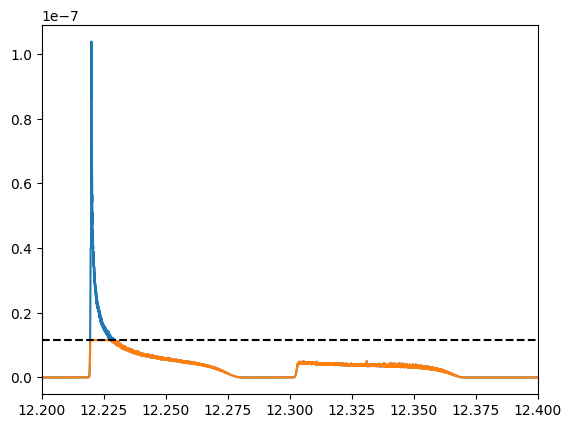

In [11]:
plt.plot(age_case1.value/1e9,  mass_transfer_rate_case1.value)
plt.plot(age_case1.value/1e9,  mass_accretion_rate_case1.value)

plt.axhline(edd_accretion_limit_case1.value, ls='--', c='k')

plt.xlim([12.2,12.4])
plt.show()

### Case 2: Phase transition during accretion

In [12]:
# Define relevant arrays
angular_momentum_case2 = np.zeros_like(age_case2.value)
ns_radius_case2 = np.zeros_like(age_case2.value) * u.km
ns_fspin_case2 = np.zeros_like(age_case2.value) * u.hertz
ns_fspin_eq_case2 = np.zeros_like(age_case2.value) * u.hertz
ns_mass_case2 = np.zeros_like(age_case2.value) * u.Msun
torque_case2 = np.zeros_like(age_case2.value) * (u.kg * (u.m**2) / (u.s**2))
r_mag_case2 = np.zeros_like(age_case2.value) * u.m
r_cor_case2 = np.zeros_like(age_case2.value) * u.m
r_lc_case2 = np.zeros_like(age_case2.value) * u.m
fastness_param_case2 = np.zeros_like(age_case2.value)
mass_accretion_rate_case2 = np.zeros_like(age_case2.value) * (u.Msun / u.yr)


# The timestep
delta_t_case2 = u.Quantity(np.diff(age_case2.value), u.yr)

# Calculate radius and spin evolution for case 2
for i in range(len(age_case2)):
    if i == 0:
        ns_mass_case2[i] = bin_data_case2["star_2_mass"][0] * u.Msun
        
        angular_momentum_case2[i] = 0
        
        ns_radius_case2[i] = (
            radius_ip(ns_mass_case2[i].value, angular_momentum_case2[i]) * u.km
        )
        ns_fspin_case2[i] = (
            spin_frequency_ip(ns_mass_case2[i].value, angular_momentum_case2[i])
            * u.hertz
        )
        
        # Initialization of mass acrretion rate (capped by Eddington limit)
        edd_accretion_limit_case2 = edd_limit(ns_mass_case2[i])
        if mass_transfer_rate_case2[i].value > edd_accretion_limit_case2.value:
            mass_accretion_rate_case2.value[i] = edd_accretion_limit_case2.value
        else:
            mass_accretion_rate_case2[i] = mass_transfer_rate_case2[i]

        torque_case2[i] = accretion_torque(
            Mdot=mass_accretion_rate_case2[i],
            fspin=ns_fspin_case2[i],
            B=magnetic_field,
            M=ns_mass_case2[i],
            R=ns_radius_case2[i],
            i=inclination_angle,
            phi=factor_phi,
            xi=factor_xi,
            delta_omega=zone_width,
        )

        r_mag_case2[i] = magnetic_radius(
            Mdot=mass_accretion_rate_case2[i],
            B=magnetic_field,
            R=ns_radius_case2[i],
            M=ns_mass_case2[i],
            phi=factor_phi,
        )

        r_cor_case2[i] = corotation_radius(fspin=ns_fspin_case2[i], M=ns_mass_case2[i])
        r_lc_case2[i] = lc_radius(ns_fspin_case2[i])

        ns_fspin_eq_case2[i] = eq_spin_frequency(ns_mass_case2[i], r_mag_case2[i])

        fastness_param_case2[i] = 0
        
    else:
        
        if mass_transfer_rate_case2[i].value > edd_accretion_limit_case2.value:
            mass_accretion_rate_case2.value[i] = edd_accretion_limit_case2.value
        else:
            mass_accretion_rate_case2[i] = mass_transfer_rate_case2[i]

        if fastness_param_case2[i - 1] <= 1:
            ns_mass_case2[i] = ns_mass_case2[i - 1] + (
                1.0 * mass_accretion_rate_case2[i - 1] * delta_t_case2[i - 1]
            )
        else:
            ns_mass_case2[i] = ns_mass_case2[i - 1]

        angular_momentum_case2[i] = angular_momentum_case2[i - 1] + (
            (torque_case2[i - 1] * delta_t_case2[i - 1]) / J0
        )
        ns_radius_case2[i] = (
            radius_ip(ns_mass_case2[i].value, angular_momentum_case2[i]) * u.km
        )
        ns_fspin_case2[i] = (
            spin_frequency_ip(ns_mass_case2[i].value, angular_momentum_case2[i])
            * u.hertz
        )

        torque_case2[i] = accretion_torque(
            Mdot=mass_accretion_rate_case2[i],
            fspin=ns_fspin_case2[i],
            B=magnetic_field,
            M=ns_mass_case2[i],
            R=ns_radius_case2[i],
            i=inclination_angle,
            phi=factor_phi,
            xi=factor_xi,
            delta_omega=zone_width,
        )

        r_mag_case2[i] = magnetic_radius(
            Mdot=mass_accretion_rate_case2[i],
            B=magnetic_field,
            R=ns_radius_case2[i],
            M=ns_mass_case2[i],
            phi=factor_phi,
        )

        r_cor_case2[i] = corotation_radius(fspin=ns_fspin_case2[i], M=ns_mass_case2[i])
        r_lc_case2[i] = lc_radius(ns_fspin_case2[i])

        ns_fspin_eq_case2[i] = eq_spin_frequency(ns_mass_case2[i], r_mag_case2[i])

        fastness_param_case2[i] = fastness_parameter(
            r_mag_case2[i].to(u.m), r_cor_case2[i].to(u.m)
        )

In [13]:
data_case2 = {
    "age [yr]" : age_case2.value,
    "donor_star_mass [Msun]" : bin_data_case2["star_1_mass"],
    "donor_star_radius [Rsun]" : bin_data_case2["star_1_radius"],
    "mass_transfer_rate [Msun/yr]" : mass_transfer_rate_case2.value,
    "mass_accretion_rate [Msun/yr]" : mass_accretion_rate_case2.value,
    "neutron_star_mass [Msun]" : ns_mass_case2.value,
    "neutron_star_radius [km]" : ns_radius_case2.value,
    "neutron_star_angular_momentum [Msun^2 / (c * G)]" : angular_momentum_case2,
    "neutron_star_spin_frequency [Hz]" : ns_fspin_case2.value,
    "neutron_star_spin_equilibrium_frequency [Hz]" : ns_fspin_eq_case2,
    "neutron_star_torque [kg * m^2 / s^2]" : torque_case2.value,
    "neutron_star_magnetic_radius [km]" : r_mag_case2.to(u.km).value,
    "neutron_star_corotation_radius [km]" : r_cor_case2.to(u.km).value,
    "neutron_star_light_cylinder_radius [km]" : r_lc_case2.to(u.km).value,
    "binary_separation [Rsun]" : bin_data_case2["binary_separation"],
    "orbital_period [days]" : bin_data_case2["period_days"],
}

df2 = pd.DataFrame(data_case2)
df2

,age [yr],donor_star_mass [Msun],donor_star_radius [Rsun],mass_transfer_rate [Msun/yr],mass_accretion_rate [Msun/yr],neutron_star_mass [Msun],neutron_star_radius [km],neutron_star_angular_momentum [Msun^2 / (c * G)],neutron_star_spin_frequency [Hz],neutron_star_spin_equilibrium_frequency [Hz],neutron_star_torque [kg * m^2 / s^2],neutron_star_magnetic_radius [km],neutron_star_corotation_radius [km],neutron_star_light_cylinder_radius [km],binary_separation [Rsun],orbital_period [days]
0,1.000000e+05,1.0000,0.897205,1.000000e-99,1.000000e-99,1.200000,13.516911,0.000000e+00,0.325474,9.731192e-37,-1.290623e+15,1.621065e+27,3364.343218,146596.872325,21.887071,8.000000
1,2.200000e+05,1.0000,0.897208,1.000000e-99,1.000000e-99,1.200000,13.516911,-5.552488e-15,0.325474,9.731192e-37,-1.290623e+15,1.621065e+27,3364.343215,146596.872168,21.887071,7.999999
2,3.640000e+05,1.0000,0.897198,1.000000e-99,1.000000e-99,1.200000,13.516911,-1.221547e-14,0.325474,9.731192e-37,-1.290623e+15,1.621065e+27,3364.343219,146596.872377,21.887070,7.999999
3,5.368000e+05,1.0000,0.897167,1.000000e-99,1.000000e-99,1.200000,13.516911,-2.021106e-14,0.325474,9.731192e-37,-1.290623e+15,1.621065e+27,3364.343216,146596.872220,21.887069,7.999998
4,7.441600e+05,1.0000,0.897102,1.000000e-99,1.000000e-99,1.200000,13.516911,-2.980576e-14,0.325474,9.731192e-37,-1.290623e+15,1.621065e+27,3364.343216,146596.872194,21.887068,7.999998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45236,1.856230e+10,0.2985,0.020572,1.000000e-99,1.000000e-99,1.519962,12.442989,1.187599e-01,205.183337,1.425405e-36,-1.967709e+23,1.359886e+27,49.510825,232.540578,89.110322,72.462703
45237,1.859238e+10,0.2985,0.020563,1.000000e-99,1.000000e-99,1.519962,12.442587,1.185476e-01,204.807049,1.425524e-36,-1.956524e+23,1.359811e+27,49.571450,232.967820,89.110322,72.462703
45238,1.862237e+10,0.2985,0.020555,1.000000e-99,1.000000e-99,1.519962,12.442190,1.183373e-01,204.434168,1.425641e-36,-1.945484e+23,1.359737e+27,49.631710,233.392745,89.110322,72.462702
45239,1.865226e+10,0.2985,0.020546,1.000000e-99,1.000000e-99,1.519962,12.441797,1.181289e-01,204.064710,1.425757e-36,-1.934589e+23,1.359663e+27,49.691597,233.815301,89.110322,72.462702


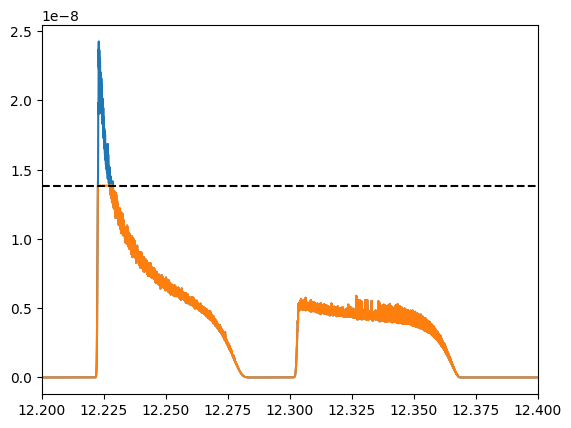

In [14]:
plt.plot(age_case2.value/1e9,  mass_transfer_rate_case2.value)
plt.plot(age_case2.value/1e9,  mass_accretion_rate_case2.value)

plt.axhline(edd_accretion_limit_case2.value, ls='--', c='k')

plt.xlim([12.2,12.4])
plt.show()

### Case 3: Phase transition after accretion

In [15]:
# Define relevant arrays
angular_momentum_case3 = np.zeros_like(age_case3.value)
ns_radius_case3 = np.zeros_like(age_case3.value) * u.km
ns_fspin_case3 = np.zeros_like(age_case3.value) * u.hertz
ns_fspin_eq_case3 = np.zeros_like(age_case3.value) * u.hertz
ns_mass_case3 = np.zeros_like(age_case3.value) * u.Msun
torque_case3 = np.zeros_like(age_case3.value) * (u.kg * (u.m**2) / (u.s**2))
r_mag_case3 = np.zeros_like(age_case3.value) * u.m
r_cor_case3 = np.zeros_like(age_case3.value) * u.m
r_lc_case3 = np.zeros_like(age_case3.value) * u.m
fastness_param_case3 = np.zeros_like(age_case3.value)
mass_accretion_rate_case3 = np.zeros_like(age_case3.value) * (u.Msun / u.yr)

# The timestep
delta_t_case3 = u.Quantity(np.diff(age_case3.value), u.yr)

# Calculate radius and spin evolution for case 3
for i in range(len(age_case3)):
    if i == 0:
        ns_mass_case3[i] = bin_data_case3["star_2_mass"][0] * u.Msun
        
        angular_momentum_case3[i] = 0
        
        ns_radius_case3[i] = (
            radius_ip(ns_mass_case3[i].value, angular_momentum_case3[i]) * u.km
        )
        ns_fspin_case3[i] = (
            spin_frequency_ip(ns_mass_case3[i].value, angular_momentum_case3[i])
            * u.hertz
        )
        
        # Initialization of mass acrretion rate (capped by Eddington limit)
        edd_accretion_limit_case3 = edd_limit(ns_mass_case3[i])
        if mass_transfer_rate_case3[i].value > edd_accretion_limit_case3.value:
            mass_accretion_rate_case3.value[i] = edd_accretion_limit_case3.value
        else:
            mass_accretion_rate_case3[i] = mass_transfer_rate_case3[i]

        torque_case3[i] = accretion_torque(
            Mdot=mass_accretion_rate_case3[i],
            fspin=ns_fspin_case3[i],
            B=magnetic_field,
            M=ns_mass_case3[i],
            R=ns_radius_case3[i],
            i=inclination_angle,
            phi=factor_phi,
            xi=factor_xi,
            delta_omega=zone_width,
        )

        r_mag_case3[i] = magnetic_radius(
            Mdot=mass_accretion_rate_case3[i],
            B=magnetic_field,
            R=ns_radius_case3[i],
            M=ns_mass_case3[i],
            phi=factor_phi,
        )

        r_cor_case3[i] = corotation_radius(fspin=ns_fspin_case3[i], M=ns_mass_case3[i])
        r_lc_case3[i] = lc_radius(ns_fspin_case3[i])

        ns_fspin_eq_case3[i] = eq_spin_frequency(ns_mass_case3[i], r_mag_case3[i])

        fastness_param_case3[i] = 0

    else:
        
        if mass_transfer_rate_case3[i].value > edd_accretion_limit_case3.value:
            mass_accretion_rate_case3.value[i] = edd_accretion_limit_case3.value
        else:
            mass_accretion_rate_case3[i] = mass_transfer_rate_case3[i]

        if fastness_param_case3[i - 1] <= 1:
            ns_mass_case3[i] = ns_mass_case3[i - 1] + (
                1.0 * mass_accretion_rate_case3[i - 1] * delta_t_case3[i - 1]
            )
        else:
            ns_mass_case3[i] = ns_mass_case3[i - 1]

        angular_momentum_case3[i] = angular_momentum_case3[i - 1] + (
            (torque_case3[i - 1] * delta_t_case3[i - 1]) / J0
        )

        ns_radius_case3[i] = (
            radius_ip(ns_mass_case3[i].value, angular_momentum_case3[i]) * u.km
        )
        ns_fspin_case3[i] = (
            spin_frequency_ip(ns_mass_case3[i].value, angular_momentum_case3[i])
            * u.hertz
        )

        torque_case3[i] = accretion_torque(
            Mdot=mass_accretion_rate_case3[i],
            fspin=ns_fspin_case3[i],
            B=magnetic_field,
            M=ns_mass_case3[i],
            R=ns_radius_case3[i],
            i=inclination_angle,
            phi=factor_phi,
            xi=factor_xi,
            delta_omega=zone_width,
        )

        r_mag_case3[i] = magnetic_radius(
            Mdot=mass_accretion_rate_case3[i],
            B=magnetic_field,
            R=ns_radius_case3[i],
            M=ns_mass_case3[i],
            phi=factor_phi,
        )

        r_cor_case3[i] = corotation_radius(fspin=ns_fspin_case3[i], M=ns_mass_case3[i])
        r_lc_case3[i] = lc_radius(ns_fspin_case3[i])

        ns_fspin_eq_case3[i] = eq_spin_frequency(ns_mass_case3[i], r_mag_case3[i])

        fastness_param_case3[i] = fastness_parameter(
            r_mag_case3[i].to(u.m), r_cor_case3[i].to(u.m)
        )

In [16]:
data_case3 = {
    "age [yr]" : age_case3.value,
    "donor_star_mass [Msun]" : bin_data_case3["star_1_mass"],
    "donor_star_radius [Rsun]" : bin_data_case3["star_1_radius"],
    "mass_transfer_rate [Msun/yr]" : mass_transfer_rate_case3.value,
    "mass_accretion_rate [Msun/yr]" : mass_accretion_rate_case3.value,
    "neutron_star_mass [Msun]" : ns_mass_case3.value,
    "neutron_star_radius [km]" : ns_radius_case3.value,
    "neutron_star_angular_momentum [Msun^2 / (c * G)]" : angular_momentum_case3,
    "neutron_star_spin_frequency [Hz]" : ns_fspin_case3.value,
    "neutron_star_spin_equilibrium_frequency [Hz]" : ns_fspin_eq_case3,
    "neutron_star_torque [kg * m^2 / s^2]" : torque_case3.value,
    "neutron_star_magnetic_radius [km]" : r_mag_case3.to(u.km).value,
    "neutron_star_corotation_radius [km]" : r_cor_case3.to(u.km).value,
    "neutron_star_light_cylinder_radius [km]" : r_lc_case3.to(u.km).value,
    "binary_separation [Rsun]" : bin_data_case3["binary_separation"],
    "orbital_period [days]" : bin_data_case3["period_days"],
}

df3 = pd.DataFrame(data_case3)
df3

,age [yr],donor_star_mass [Msun],donor_star_radius [Rsun],mass_transfer_rate [Msun/yr],mass_accretion_rate [Msun/yr],neutron_star_mass [Msun],neutron_star_radius [km],neutron_star_angular_momentum [Msun^2 / (c * G)],neutron_star_spin_frequency [Hz],neutron_star_spin_equilibrium_frequency [Hz],neutron_star_torque [kg * m^2 / s^2],neutron_star_magnetic_radius [km],neutron_star_corotation_radius [km],neutron_star_light_cylinder_radius [km],binary_separation [Rsun],orbital_period [days]
0,1.000000e+05,1.000000,0.897189,1.000000e-99,1.000000e-99,1.200000,13.516911,0.000000e+00,0.325474,9.731192e-37,-1.290623e+15,1.621065e+27,3364.343218,146596.872325,43.773606,22.627000
1,2.200000e+05,1.000000,0.897191,1.000000e-99,1.000000e-99,1.200000,13.516911,-5.552488e-15,0.325474,9.731192e-37,-1.290623e+15,1.621065e+27,3364.343215,146596.872168,43.773606,22.627000
2,3.640000e+05,1.000000,0.897182,1.000000e-99,1.000000e-99,1.200000,13.516911,-1.221547e-14,0.325474,9.731192e-37,-1.290623e+15,1.621065e+27,3364.343219,146596.872377,43.773606,22.627000
3,5.368000e+05,1.000000,0.897151,1.000000e-99,1.000000e-99,1.200000,13.516911,-2.021106e-14,0.325474,9.731192e-37,-1.290623e+15,1.621065e+27,3364.343216,146596.872220,43.773606,22.627000
4,7.441600e+05,1.000000,0.897086,1.000000e-99,1.000000e-99,1.200000,13.516911,-2.980576e-14,0.325474,9.731192e-37,-1.290623e+15,1.621065e+27,3364.343216,146596.872194,43.773606,22.627000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30704,1.732769e+10,0.331948,0.019228,1.000000e-99,1.000000e-99,1.572825,12.236681,1.497845e-01,245.229553,1.524808e-36,-3.038691e+23,1.315025e+27,44.466085,194.566483,164.143068,180.383402
30705,1.735203e+10,0.331948,0.019222,1.000000e-99,1.000000e-99,1.572825,12.236192,1.495194e-01,244.779410,1.524965e-36,-3.021263e+23,1.314935e+27,44.520582,194.924285,164.143068,180.383402
30706,1.737631e+10,0.331948,0.019215,1.000000e-99,1.000000e-99,1.572825,12.235707,1.492564e-01,244.332834,1.525120e-36,-3.004043e+23,1.314845e+27,44.574814,195.280556,164.143068,180.383402
30707,1.740054e+10,0.331948,0.019208,1.000000e-99,1.000000e-99,1.572825,12.235226,1.489954e-01,243.889834,1.525274e-36,-2.987029e+23,1.314757e+27,44.628775,195.635262,164.143068,180.383402


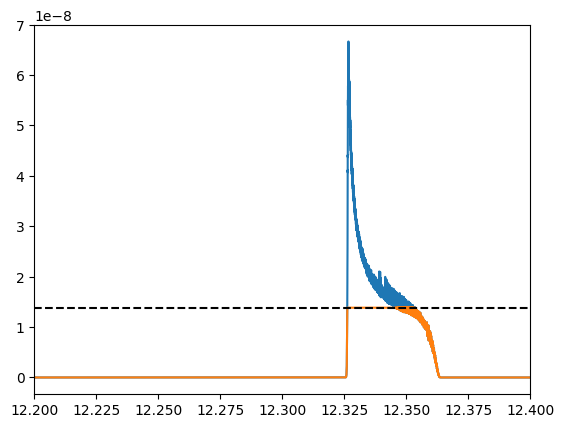

In [17]:
plt.plot(age_case3.value/1e9,  mass_transfer_rate_case3.value)
plt.plot(age_case3.value/1e9,  mass_accretion_rate_case3.value)

plt.axhline(edd_accretion_limit_case3.value, ls='--', c='k')

plt.xlim([12.2,12.4])
plt.show()

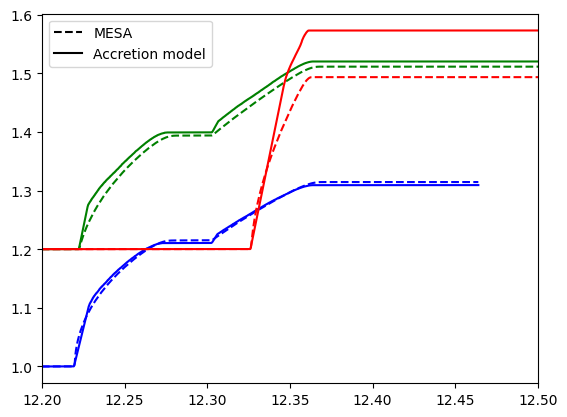

In [18]:
plt.plot(age_case1/1e9, bin_data_case1["star_2_mass"], ls='--', c='b')
plt.plot(age_case1/1e9, ns_mass_case1, c='b')

plt.plot(age_case2/1e9, bin_data_case2["star_2_mass"], ls='--', c='g')
plt.plot(age_case2/1e9, ns_mass_case2, c='g')

plt.plot(age_case3/1e9, bin_data_case3["star_2_mass"], ls='--', c='r')
plt.plot(age_case3/1e9, ns_mass_case3, c='r')

plt.plot([],[],label='MESA',c='k', ls='--')
plt.plot([],[],label="Accretion model",c='k')

plt.xlim([12.2, 12.5])

plt.legend()
plt.show()

## Fit the M_b - M_g data to find a model for baryonic mass

In [19]:
df = pd.read_csv('data/ACB5/combined_ACB5_data.csv')
df.head()

,E_center,Radius,Mass,Quad,Baryon_M,Jstar,Om_surf
0,100.000000,31.629888,0.121311,0.0,0.121793,0.0,0.0
1,106.122449,27.312850,0.130235,0.0,0.130836,0.0,0.0
2,112.244898,24.160742,0.140343,0.0,0.141094,0.0,0.0
3,118.367347,21.886025,0.151161,0.0,0.152092,0.0,0.0
4,124.489796,20.171618,0.162737,0.0,0.163882,0.0,0.0


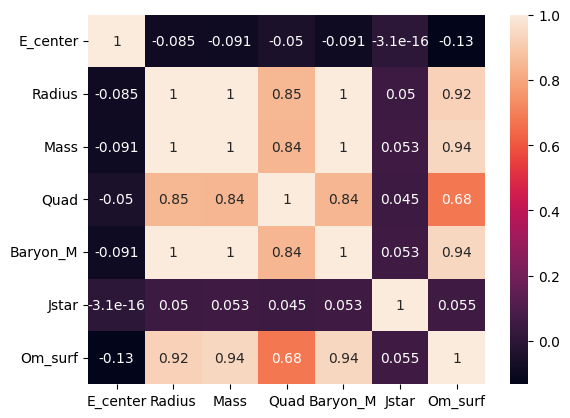

In [20]:
plt.style.use("default")

_ = sns.heatmap(df.corr(), annot=True)

In [21]:
mask = (
    (df["Mass"] <= 2.0)
    & (df["Mass"] >= 1.0)
    & (df["Baryon_M"] >= 1.0)
    & (df["Radius"] <= 18)
)

In [22]:
mg = df["Mass"][mask]
mb = df["Baryon_M"][mask]

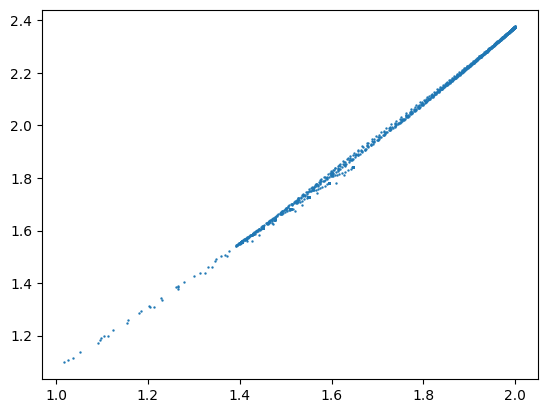

In [23]:
_ = plt.scatter(mg, mb, s=0.5)

In [24]:
popt, pcov = curve_fit(f=lambda x,m,b:m*x+b, xdata=mg, ydata=mb)

In [25]:
m,b = popt
print(m,b)

1.371596121885002 -0.3770418791648211


In [26]:
x_fit = np.linspace(np.min(mg), np.max(mg))
y_fit = m*x_fit + b

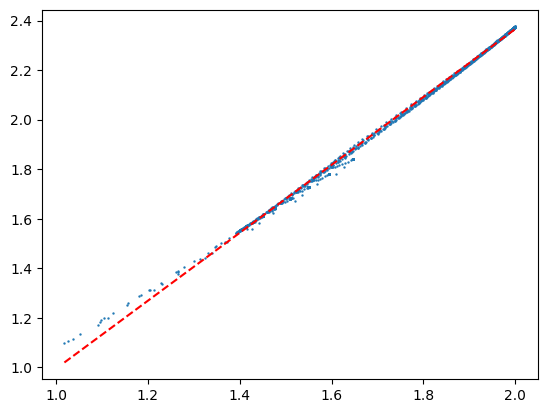

In [27]:
plt.scatter(mg, mb, s=0.5)
plt.plot(x_fit, y_fit, ls='--', lw=1.5, c='r')

In [28]:
m1_bar_mass = m * ns_mass_case1.value + b
m2_bar_mass = m * ns_mass_case2.value + b
m3_bar_mass = m * ns_mass_case3.value + b

In [29]:
df1["neutron_star_bar_mass [Msun]"] = m1_bar_mass
df2["neutron_star_bar_mass [Msun]"] = m2_bar_mass
df3["neutron_star_bar_mass [Msun]"] = m3_bar_mass

## Write data to csv files

In [30]:
# # Uncomment the following code segment to write the
# # data into csv files

# df1.to_csv("data/model_m1.csv", index=False)
# df2.to_csv("data/model_m2.csv", index=False)
# df3.to_csv("data/model_m3.csv", index=False)

---

# Sandbox

## Create a polynomial regression model to predict the baryonic mass

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

In [32]:
df = pd.read_csv('data/ACB5/combined_ACB5_data.csv')
df.head()

,E_center,Radius,Mass,Quad,Baryon_M,Jstar,Om_surf
0,100.000000,31.629888,0.121311,0.0,0.121793,0.0,0.0
1,106.122449,27.312850,0.130235,0.0,0.130836,0.0,0.0
2,112.244898,24.160742,0.140343,0.0,0.141094,0.0,0.0
3,118.367347,21.886025,0.151161,0.0,0.152092,0.0,0.0
4,124.489796,20.171618,0.162737,0.0,0.163882,0.0,0.0


Start with a simple linear regression model

In [33]:
mass_mask = df['Mass'] <= 2
X_train = df['Mass'][mass_mask].values.reshape(-1,1)
y_train = df['Baryon_M'][mass_mask]

print(X_train.shape, y_train.shape)

(1494, 1) (1494,)


In [34]:
regressor = LinearRegression(n_jobs=-1)
regressor.fit(X_train, y_train)

LinearRegression(n_jobs=-1)

In [35]:
# Get the coefficients
slope = regressor.coef_[0]
intercept = regressor.intercept_

# Display the linear regression formula
linear_formula = f'Baryon_M = {slope:.4f} * Mass + {intercept:.4f}'
linear_formula

'Baryon_M = 1.2930 * Mass + -0.2407'

Let's check some polynomial regression models

In [36]:
# Function to fit polynomial regression and calculate R^2
def polynomial_regression(X, y, degree):
    polynomial_features = PolynomialFeatures(degree=degree)
    X_poly = polynomial_features.fit_transform(X)
    
    model = LinearRegression()
    model.fit(X_poly, y)
    
    y_poly_pred = model.predict(X_poly)
    r2 = r2_score(y, y_poly_pred)
    
    # Extract coefficients and intercept
    intercept = model.intercept_
    coefficients = model.coef_

    # Print the polynomial regression formula
    terms = polynomial_features.get_feature_names_out(['Mass'])
    formula = f"{intercept:.4f}"
    for coef, term in zip(coefficients, terms):
        formula += f" + ({coef:.4f})*{term}"

    print(f"Polynomial regression formula: y = {formula}")
    
    return model, r2, polynomial_features

In [37]:
# Test polynomial regression with degrees 2 and 3
model_2, r2_2, poly_features_2 = polynomial_regression(X_train, y_train, 2)
model_3, r2_3, poly_features_3 = polynomial_regression(X_train, y_train, 3)

r2_2, r2_3

Polynomial regression formula: y = 0.0409 + (0.0000)*1 + (0.8628)*Mass + (0.1513)*Mass^2
Polynomial regression formula: y = -0.0123 + (0.0000)*1 + (1.0757)*Mass + (-0.0475)*Mass^2 + (0.0533)*Mass^3


(0.9982618592973622, 0.9983677688664951)

In [38]:
X1_poly = poly_features_3.transform(ns_mass_case1.value.reshape(-1,1))
X2_poly = poly_features_3.transform(ns_mass_case2.value.reshape(-1,1))
X3_poly = poly_features_3.transform(ns_mass_case3.value.reshape(-1,1))

In [39]:
m1_mass_bar = model_3.predict(X1_poly)
m2_mass_bar = model_3.predict(X2_poly)
m3_mass_bar = model_3.predict(X3_poly)

In [40]:
df1["neutron_star_bar_mass [Msun]"] = m1_mass_bar
df2["neutron_star_bar_mass [Msun]"] = m2_mass_bar
df3["neutron_star_bar_mass [Msun]"] = m3_mass_bar

## Create a simple neural network to predict the baryonic mass

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.regularizers import l2
from keras.models import Model
from scipy.stats import probplot, shapiro

2024-07-29 23:59:26.913989: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [42]:
# Load data
df = pd.read_csv('data/ACB5/combined_ACB5_data.csv')
features = ['Mass', 'Om_surf']
mass_mask = df['Mass'] <= 2
X = df[features][mass_mask].values
y = np.log(df['Baryon_M'][mass_mask])  # Log transformation of the target variable

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [43]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
E_center,2000.0,8.945470e+02,5.144983e+02,100.000000,407.046980,874.496644,1341.946309,1.809396e+03
Radius,2000.0,3.491839e+09,6.313399e+10,9.834950,10.468604,11.479424,13.972185,1.844374e+12
Mass,2000.0,4.573985e+05,7.795640e+06,0.121311,1.549723,1.898648,2.000171,2.262316e+08
Quad,2000.0,2.694249e+34,8.283714e+35,0.000000,0.047622,0.237783,1.664616,3.423740e+37
Baryon_M,2000.0,4.837277e+05,8.248039e+06,0.121793,1.728526,2.222463,2.376562,2.393767e+08
Jstar,2000.0,2.250000e-01,1.436500e-01,0.000000,0.100000,0.225000,0.350000,4.500000e-01
Om_surf,2000.0,9.896839e+05,1.143957e+07,0.000000,848.543037,1912.904662,3256.771376,2.545258e+08


In [44]:
# Define the model creation function
def create_base_model(neurons1=64, neurons2=32, l2_penalty=0.001):
    inputs = Input(shape=(X_train_scaled.shape[1],))
    x = Dense(neurons1, activation="relu", kernel_regularizer=l2(l2_penalty))(inputs)
    x = Dense(neurons2, activation="relu", kernel_regularizer=l2(l2_penalty))(x)
    outputs = Dense(1, kernel_regularizer=l2(l2_penalty))(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer="adam", loss="mse")
    return model


def create_advanced_model(
    neurons1=512,
    neurons2=256,
    neurons3=256,
    neurons4=128,
    dropout_rate=0.5,
    l2_penalty=0.001,
):
    inputs = Input(shape=(X_train_scaled.shape[1],))
    x = Dense(neurons1, activation="relu", kernel_regularizer=l2(l2_penalty))(inputs)
    x = Dropout(dropout_rate)(x)
    x = Dense(neurons2, activation="relu", kernel_regularizer=l2(l2_penalty))(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(neurons3, activation="relu", kernel_regularizer=l2(l2_penalty))(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(neurons4, activation="relu", kernel_regularizer=l2(l2_penalty))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, kernel_regularizer=l2(l2_penalty))(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer="adam", loss="mse")
    return model


# Define early stopping callback
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

# Create the model
model = create_base_model()

# Train the model
history = model.fit(
    X_train_scaled,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=0,
)

In [45]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,917 (27.02 KB)

 Trainable params: 2,305 (9.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,612 (18.02 KB)

In [46]:
# Predict and evaluate
y_train_pred_nn = model.predict(X_train_scaled).flatten()
y_test_pred_nn = model.predict(X_test_scaled).flatten()

r2_train_nn = r2_score(y_train, y_train_pred_nn)
r2_test_nn = r2_score(y_test, y_test_pred_nn)

print(f"Training R^2: {r2_train_nn}")
print(f"Test R^2: {r2_test_nn}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Training R^2: 0.9896334043143595
Test R^2: 0.9969827756732784


In [47]:
plt.style.use(["default", "science"])

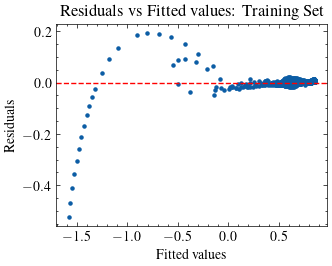

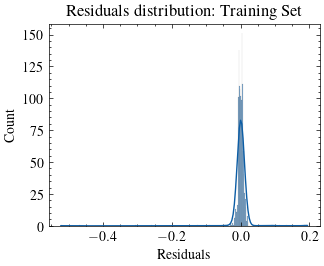

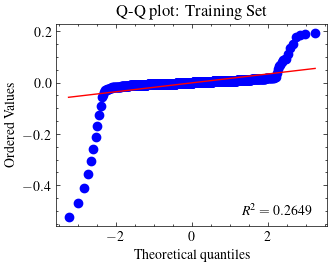

Shapiro-Wilk test for normality (p-value): 0.0


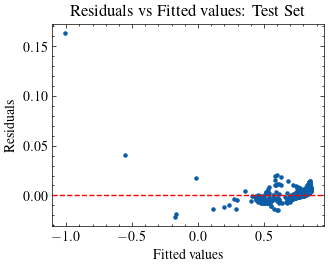

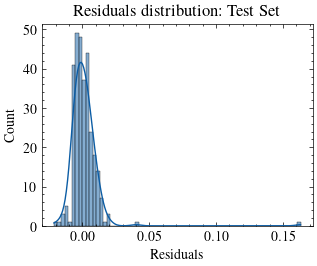

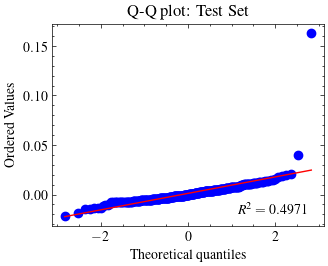

Shapiro-Wilk test for normality (p-value): 6.011225060966079e-28


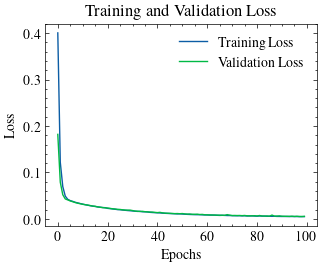

In [48]:
# Residual Analysis
def plot_residuals(y_true, y_pred, title):
    residuals = y_true - y_pred

    # Residuals vs. Fitted values plot
    plt.scatter(y_pred, residuals, s=5)
    plt.axhline(y=0, color="r", linestyle="--")
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title(f"Residuals vs Fitted values: {title}")
    plt.show()
    plt.clf()

    # Residuals histogram
    sns.histplot(residuals, kde=True)
    plt.xlabel("Residuals")
    plt.title(f"Residuals distribution: {title}")
    plt.show()
    plt.clf()

    # Q-Q plot for normality check
    probplot(residuals, dist="norm", plot=plt, rvalue=True)
    plt.title(f'Q-Q plot: {title}')
    plt.show()
    plt.clf()

    # Shapiro-Wilk test for normality
    shapiro_test = shapiro(residuals)
    print(f"Shapiro-Wilk test for normality (p-value): {shapiro_test.pvalue}")


# Plot residuals and check for normality for Neural Network model
plot_residuals(y_train, y_train_pred_nn, "Training Set")
plot_residuals(y_test, y_test_pred_nn, "Test Set")

# Plot training history
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

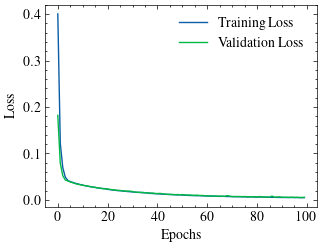

In [49]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
# plt.savefig("train_vs_val_loss.png", dpi=300, bbox_inches='tight')

In [50]:
residuals_train = y_train - y_train_pred_nn
residuals_test = y_test - y_test_pred_nn

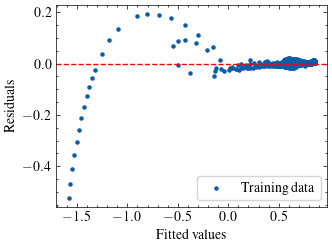

In [51]:
# Residuals vs. Fitted values plot
plt.scatter(y_train_pred_nn, residuals_train, s=5, label='Training data')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')


plt.legend(loc='lower right', frameon=True)
plt.show()
# plt.savefig("res_vs_fit_train.png", dpi=300, bbox_inches='tight')

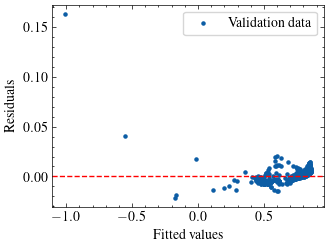

In [52]:
# Residuals vs. Fitted values plot
plt.scatter(y_test_pred_nn, residuals_test, s=5, label='Validation data')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

plt.legend(frameon=True)

plt.show()
# plt.savefig("res_vs_fit_test.png", dpi=300, bbox_inches='tight')

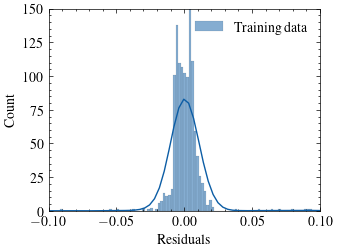

In [53]:
# Residuals histogram
sns.histplot(residuals_train, kde=True, label="Training data")
plt.xlabel('Residuals')

plt.xlim([-0.1, 0.1])
plt.ylim([0,150])

plt.legend()
plt.show()
# plt.savefig("res_distr_train.png", dpi=300, bbox_inches='tight')

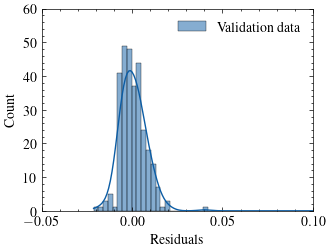

In [54]:
# Residuals histogram
sns.histplot(residuals_test, kde=True, label='Validation data')
plt.xlabel('Residuals')

plt.xlim([-0.05, 0.1])
plt.ylim([0, 60])

plt.legend()
plt.show()
# plt.savefig("res_distr_test.png", dpi=300, bbox_inches='tight')

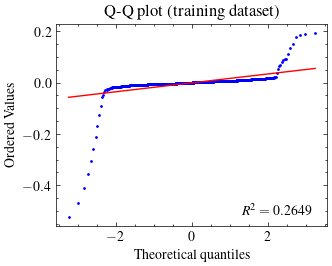

In [55]:
# Q-Q plot for normality check
fig, ax = plt.subplots(1,1)
probplot(residuals_train, dist="norm", plot=plt, rvalue=True)

ax.get_lines()[0].set_markersize(1)

plt.title("Q-Q plot (training dataset)")
plt.show()
# plt.savefig("qq_plot_train.png", dpi=300, bbox_inches='tight')

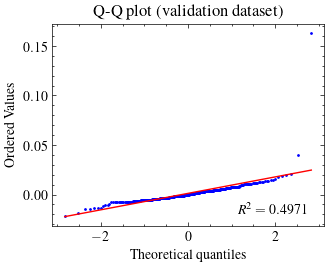

In [56]:
# Q-Q plot for normality check
fig, ax = plt.subplots(1,1)
probplot(residuals_test, dist="norm", plot=plt, rvalue=True)

ax.get_lines()[0].set_markersize(1)


plt.title("Q-Q plot (validation dataset)")
plt.show()
# plt.savefig("qq_plot_test.png", dpi=300, bbox_inches='tight')

In [57]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.stats.stattools import durbin_watson

# Calculate additional metrics
mae_train_nn = mean_absolute_error(y_train, y_train_pred_nn)
mae_test_nn = mean_absolute_error(y_test, y_test_pred_nn)

rmse_train_nn = np.sqrt(mean_squared_error(y_train, y_train_pred_nn))
rmse_test_nn = np.sqrt(mean_squared_error(y_test, y_test_pred_nn))

mape_train_nn = mean_absolute_percentage_error(y_train, y_train_pred_nn)
mape_test_nn = mean_absolute_percentage_error(y_test, y_test_pred_nn)

# Calculate Durbin-Watson statistic
dw_train_nn = durbin_watson(y_train - y_train_pred_nn)
dw_test_nn = durbin_watson(y_test - y_test_pred_nn)

# Adjusted R^2 calculation function
def adjusted_r2(r2, n, k):
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)

n_train = len(y_train)
n_test = len(y_test)
k = X_train_scaled.shape[1]

adj_r2_train_nn = adjusted_r2(r2_train_nn, n_train, k)
adj_r2_test_nn = adjusted_r2(r2_test_nn, n_test, k)

print(f"Training MAE (Neural Network): {mae_train_nn}")
print(f"Test MAE (Neural Network): {mae_test_nn}")

print(f"Training RMSE (Neural Network): {rmse_train_nn}")
print(f"Test RMSE (Neural Network): {rmse_test_nn}")

print(f"Training MAPE (Neural Network): {mape_train_nn}")
print(f"Test MAPE (Neural Network): {mape_test_nn}")

print(f"Training Durbin-Watson (Neural Network): {dw_train_nn}")
print(f"Test Durbin-Watson (Neural Network): {dw_test_nn}")

print(f"Training Adjusted R^2 (Neural Network): {adj_r2_train_nn}")
print(f"Test Adjusted R^2 (Neural Network): {adj_r2_test_nn}")


Training MAE (Neural Network): 0.00945467720979835
Test MAE (Neural Network): 0.005905554407854327
Training RMSE (Neural Network): 0.03360511593478405
Test RMSE (Neural Network): 0.011735535608036677
Training MAPE (Neural Network): 0.022094505923907146
Test MAPE (Neural Network): 0.022569180996158657
Training Durbin-Watson (Neural Network): 1.8655880345087403
Test Durbin-Watson (Neural Network): 1.9583322144293163
Training Adjusted R^2 (Neural Network): 0.9896160106974373
Test Adjusted R^2 (Neural Network): 0.9969623890224222


### Re-train the ANN in all data without spliting

In [58]:
X_scaled = scaler.transform(X)

In [59]:
# Create the model
model = create_base_model()

# Train the model
_ = model.fit(
    X_scaled,
    y,
    epochs=100,
    batch_size=32,
    verbose=0,
)

In [60]:
# Save the model as an HDF5 file
model.save('baryon_mass_regressor.keras')

In [61]:
feature_labels = [
        "neutron_star_mass [Msun]",
        "neutron_star_spin_frequency [Hz]",
]

# Preprocess the new data (scale it using the same scaler)
X1_scaled = scaler.transform(df1[feature_labels].values)
X2_scaled = scaler.transform(df2[feature_labels].values)
X3_scaled = scaler.transform(df3[feature_labels].values)

# Predict using the neural network model
y1_predictions_log = model.predict(X1_scaled).flatten()
y2_predictions_log = model.predict(X2_scaled).flatten()
y3_predictions_log = model.predict(X3_scaled).flatten()

# Convert predictions back from log transformation
y1_predictions = np.exp(y1_predictions_log)
y2_predictions = np.exp(y2_predictions_log)
y3_predictions = np.exp(y3_predictions_log)

1458/1458 ━━━━━━━━━━━━━━━━━━━━ 1s 820us/step
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 1s 690us/step
960/960 ━━━━━━━━━━━━━━━━━━━━ 1s 664us/step


In [62]:
# df1["neutron_star_bar_mass [Msun]"] = y1_predictions
# df2["neutron_star_bar_mass [Msun]"] = y2_predictions
# df3["neutron_star_bar_mass [Msun]"] = y3_predictions